In [718]:
from processing_functions import *
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")


In [719]:
# reading datasets
personal_data = pd.read_csv('./dataset/Ovarian/ovar_data_mar22_d032222.csv')
screen_data = pd.read_csv('./dataset/Ovarian/Screening/ovar_screen_data_mar22_d032222.csv')
screen_abnorm_data = pd.read_csv('./dataset/Ovarian/Screening Abnormalities/ovar_scrsub_data_mar22_d032222.csv')

## Preprocessing
For some of the datasets we determined some of the features to not be useful for analysis. For every dataset that includes `build` features. 

For personal dataset we removed all `ovar_` features since they are a direct result of the cancer diagnosis and should not be used predict cancer. 

For the screen data dataset it was determined that `examinerid_` features do not bring the value to the dataset since they represet 'Examiner ID made by concatentating center and exam ID for overall screen result.' and cannot be the cause of the cancer. We also drop all of the remaining

In [720]:
# Drop profy features
proxy_features_personal_dataset = [
    'fstcan_exitdays', # Days from trial entry (randomization) to first cancer diagnosis for participants with cancer, or to trial exit otherwise. Only cancers occuring during the trial are used to determine exit.
    'fstcan_exitstat', # Status of the participant at exit for first cancer incidence. Only cancers occuring during the trial are used to determine exit.
    'fstcan_exitage',
    'f_dthovar', # Is ovarian cancer the underlying cause of death? This conclusion is based on the information from the death certificate and death review.
    'f_codeath_cat', # Categorized underlying cause of death.
    'f_cancersite', # Underlying cause of death from cancer.
    'f_seer_death', # Underlying cause of death.
    'd_codeath_cat', # Categorized underlying cause of death.
    'd_dthovar', # Is Ovarian Cancer The Underlying Cause Of Death?
    'd_cancersite', # 
    'd_seer_death', # Underlying cause of death.
    'ph_ovar_muq', # Did the participant have a personal history of ovarian/ft/pt cancer prior to MUQ analysis entry? 
    'ph_ovar_sqx', # 
    'entrydays_muq', # 
    'ca125_src1', # 
    'ph_ovar_dhq', # 
    'dth_days', # 
    'bq_compdays',
    'bq_adminm',
    'bq_returned',
    'ssmokea_f',
    'orem_fyro',
    'arm',
    ]

proxy_features_screen_dataset = [
    'QAMETHOD',
    'tvudays_pvis1',
    'tvudays_pvis2',
    'tvudays_pvis3',
    'tvures_qvis1',
    'tvures_qvis2',
    'tvures_qvis3',
    'tvu_assess_days_q',
    'ca125ii_src', # 
    'medcomp', # 
    'ca125_src', # 
    'tvures_pvis3', # It is completely missing for non-cancer patients
    'physid',
    'detl_q',
    'detr_q',
    'ca125i_assess_days',
]

personal_data = personal_data.drop(proxy_features_personal_dataset, axis=1)
screen_data = screen_data.drop(proxy_features_screen_dataset, axis=1)

# Remove all ovar_ features
personal_data = remove_featues_startswith(personal_data, ['ovar_', 'mortality', 'reconsent', 'is_dead', 'build', 'ca125_src', 'ca125_days', 'tvu_days', 'ca125'], ['ovar_cancer', 'ovar_cancer_diagdays'])

# Remove all inad_ and examinerid_ and build_ features
screen_data = remove_featues_startswith(screen_data, ['inad_', 'examinerid', 'build'])

# Drop not useful cols and convert categorical into numerical in screen abnormalities
screen_abnorm_data = remove_featues_startswith(screen_abnorm_data, ['build'])

Number of ovar_ cols: 50
['ovar_reasfoll', 'ovar_reassurv', 'ovar_reassymp', 'ovar_reasoth', 'ovar_cancer', 'ovar_intstat_cat', 'ovar_annyr', 'ovar_cancer_site', 'ovar_stage', 'ovar_stage_7e', 'ovar_stage_t', 'ovar_stage_n', 'ovar_stage_m', 'ovar_clinstage', 'ovar_clinstage_7e', 'ovar_clinstage_t', 'ovar_clinstage_n', 'ovar_clinstage_m', 'ovar_pathstage', 'ovar_pathstage_7e', 'ovar_pathstage_t', 'ovar_pathstage_n', 'ovar_pathstage_m', 'ovar_grade', 'ovar_topography', 'ovar_morphology', 'ovar_behavior', 'ovar_histtype', 'ovar_exitstat', 'ovar_exitage', 'ovar_seer', 'ovar_cancer_first', 'ovar_curative_surg', 'ovar_curative_chemo', 'ovar_primary_trt', 'ovar_num_heslide_imgs', 'ovar_has_deliv_heslide_img', 'ovar_exitdays', 'ovar_primary_trt_days', 'ovar_cancer_diagdays', 'ovar_mra_stat0', 'ovar_mra_stat1', 'ovar_mra_stat2', 'ovar_mra_stat3', 'ovar_mra_stat4', 'ovar_mra_stat5', 'ovar_eligible_bq', 'ovar_eligible_sqx', 'ovar_eligible_dhq', 'ovar_eligible_dqx']
Number of mortality cols: 3
['m

In [721]:
print_records_vs_unique(personal_data, 'plco_id', 'personal')
# Check the number of people with cancer
personal_data_cancer = personal_data[personal_data['ovar_cancer']==1]
print(f"Num of patients with cancer: {len(personal_data_cancer)}")
# Check the number of people without cancer
personal_data_no_cancer = personal_data[personal_data['ovar_cancer']==0]
print(f"Num of patients without cancer: {len(personal_data_no_cancer)}")

Num of records in personal dataset: 78209
Num of unique plco_id in personal dataset: 78209
Num of patients with cancer: 613
Num of patients without cancer: 77596


## Merging data into features and mean imputing


## `TODO:` should we mean impute before and after or just after? Also, should we use labeled imputation?

`TODO:` select most recent feature for abnormalities. Select largest feature for side

Deciding which patients will be in training vs test set to learn the mean imputation parameters.

Mean imputation: https://www.kaggle.com/general/226554

In [722]:
# X_train, X_test, y_train, y_test = train_test_split(personal_data['plco_id'], personal_data['ovar_cancer'], test_size = 0.2, random_state = 42)

In [723]:
def labeled_mean_impute(df, label_df, columns, id_col, label_col):
    label_dict = {}
    df_list = []
    for label in sorted(label_df[label_col].unique()):
        label_dict[label] = label_df[label_df[label_col] == label][id_col].to_list()

    for label, id_list in label_dict.items():
        filtered_df = df[df[id_col].isin(id_list)]
        for col in columns:
            filtered_df[col] = filtered_df[col].fillna(filtered_df[col].mean())
        df_list.append(filtered_df)

    return pd.concat(df_list, axis=0)

In [724]:
# personal_data = labeled_mean_impute(personal_data, personal_data, select_numeric_columns(personal_data), id_col='plco_id', label_col='ovar_cancer')

To predict whether person will get cancer in the next 1, 3, 5, 10 years we need to determine what feature describes when person got cancer. In our case that features is `ovar_cancer_diagdays`. We are going to use that feature in the following manner: we are going to have a sliding window to determine whether the person gets cancer withing the period of that window. Then, we are going to slide that window by one year and determine a new batch of people who are going to get cancer in that window and so on. For each of the features that are measured across multiple years we only going to use a record that is at the beginning of the interval. 

Since `ovar_cancer_diagdays` is described in days and we are concerned about the years when people will get cancer we need to convert this feature into years. Since people got cancer from year 1 to year 19, we are going to bucket it into 19 buckets corresponding to year when person got cancer. 

In [725]:
ovar_cancer_diagdays_range = personal_data['ovar_cancer_diagdays'].max() / 365
print(f'Max value of ovar_cancer_diagdays in years is {ovar_cancer_diagdays_range}')


Max value of ovar_cancer_diagdays in years is 18.89041095890411


In [726]:
personal_data['ovar_cancer_years'] = pd.cut(personal_data['ovar_cancer_diagdays'], bins=19, labels=list(range(0, 19)), include_lowest=True)
personal_data['ovar_cancer_years'] = pd.to_numeric(personal_data['ovar_cancer_years'])

We can also set every healthy persons '`ovar_cancer_years`' to 100 so that it is easier to filter them

In [727]:
personal_data['ovar_cancer_years'] = personal_data['ovar_cancer_years'].fillna(100)

In [728]:
# personal_data[(personal_data['ovar_cancer_diagdays'] > 365) & (personal_data['ovar_cancer_diagdays'] < 400)][['ovar_cancer_years', 'ovar_cancer_diagdays']]

When merging abnormalities dataset we are going to keep each record for each `study_yr`, select the latest `VISIT` if there are multiple and take the largest value of each column over all of the remaining records. 

`TODO:` merge ca125 and ca125ii

`TODO:` some features in the person dataset represent observations over multiple years

`TODO:` bucket age by 3 or 5 years

In [729]:
def merge_data_over_years(person_df, screen_df, abnorm_df, screen_join='left', abrorm_join='left'):
    on_col = 'ovar_cancer_years'
    # Select max data for each of the features in the abnorm_df, while varied over plco_id and study_yr
    abnorm_df = abnorm_df.groupby(['plco_id', 'study_yr'], as_index=False).max()
    df_list = []
    df_final = pd.DataFrame()
    for base_year in range(0, 18):
        df = person_df
        # individuals who got cancer before the beginning of this window should not be included in the current window
        df = df[df[on_col] >= base_year]
        # TODO: increment certain features by base year
        # If base year is 0 through 5 we have data on the scan performed on that year, so we can attach that data
        if base_year <= 5: 
            df = df.merge(screen_df[screen_df['study_yr'] == base_year], how=screen_join)
        # If base year is 0 through 53 we have data on the abnormality on that year, so we can attach that data
        if base_year <= 3: 
            filtered_abnorm = abnorm_df[abnorm_df['study_yr'] == base_year]
            df = df.merge(filtered_abnorm, how=abrorm_join)
        # Assign new labels whether people will get cancer withing next 1, 3, 5, 10 years based on the current data
        for window_size in [1, 3, 5, 10]:
            if base_year + window_size >= 20:
                continue
            label_feature = f'cancer_in_next_{window_size}_years'
            df.loc[df[df[on_col] >= base_year + window_size].index, label_feature] = 0
            # df[label_feature] = 0
            index = df[df[on_col] < base_year + window_size].index
            df.loc[index, label_feature] = 1
            # TODO: can I do this?
            # df = df[df[label_feature].notnull()]
        df_final = pd.concat([df_final, df])
        df_final = df_final.drop_duplicates()
    return df_final


In [730]:
abnorm_filtered = screen_abnorm_data.drop(['side', 'source', 'VISIT', 'sbcd'], axis=1)
personal_filtered = personal_data.drop(['ovar_cancer_diagdays'], axis=1)
merged_df = merge_data_over_years(personal_filtered, screen_data, abnorm_filtered, screen_join='left', abrorm_join='left')

In [731]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463315 entries, 0 to 78208
Columns: 198 entries, ovar_cancer to cancer_in_next_10_years
dtypes: float64(179), int64(18), object(1)
memory usage: 703.4+ MB


In [732]:
# TODO: median vs mean impute

class LabeledImmpute:
    def __init__(self) -> None:
        self.mean = None
        self.median = None

    def fit(self, df, label_col):
        self.mean = df.groupby([label_col], as_index=False).mean()
        self.median = df.groupby([label_col], as_index=False).median()

    def transform_base(self, df, label_col, values_df):
        df_missing_value = df[select_numeric_columns(df)]
        df_missing_value = get_missing_values_cols(df_missing_value)
        df_missing_value = df_missing_value[df_missing_value.percent_missing > 0]
        missing_val_cols = df_missing_value['column_name'].to_list()
        df_list = []
        for val in df[label_col].unique():
            values_dict = values_df[values_df[label_col] == val].to_dict('records')[0]
            labeled_df = df[df[label_col] == val]
            for col in missing_val_cols:
                labeled_df[col] = labeled_df[col].fillna(values_dict[col])
            df_list.append(labeled_df)
        return pd.concat(df_list)

    def transform_median(self, df, label_col):
        return self.transform_base(df, label_col, self.median)

    def transform_mean(self, df, label_col):
        return self.transform_base(df, label_col, self.mean)
    
    def transform(self, df, label_col, strategy):
        if strategy == 'mean':
            return self.transform_mean(df, label_col)
        return self.transform_median(df, label_col)

In [733]:
# Drop features that are 100% missing
merged_df = drop_cols_missing_percentage(100, merged_df, 'merged_df')

Removing features that are over 100% missing
0 columns were over 100 missing. This is the list of columns: []
The table of features missing over 100 percentage: 
+---------------+---------------+---------------+-------------------+
| column_name   | num_missing   | num_present   | percent_missing   |
|---------------+---------------+---------------+-------------------|
+---------------+---------------+---------------+-------------------+


In [734]:
merged_df = merged_df.drop(['study_yr'], axis=1)

In [735]:
# get_cols_missing_percentage(50, merged_df, 'imputed_df', show_missing=True)

## Merging Datasets

## `TODO:` should we dismiss people who do not have records in screen dataset. Abnormalities dataset? Run tests on all of the combinations of merges and imputations? 

I realized that I was doing labeled mean imputation, which should not happen. So, I performed imputation after I merged cancer and no_cancer datasets back together. Without labeled mean imputation, gaussian NB and logistic regression do not perform well. 

### `TODO:` do labeled mean impute by calculating labeled mean values for each feature before merging them and then using those means to fill out the missing data later. So, have two steps fit and fill out. 

In [736]:
from sklearn.utils import resample
def resample_max(df, label, n_max_per_class, replace=True):

    df_majority = df[df[label] ==0]
    df_minority = df[df[label] ==1]

    # downsample df_majority class
    df_majority_downsampled = resample(df_majority, 
                                    replace=False,     # sample with replacement
                                    n_samples=n_max_per_class,    # to match majority class
                                    random_state=44) 

    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                    replace=replace,     # sample with replacement
                                    n_samples=n_max_per_class,    # to match majority class
                                    random_state=44) 

    # Combine majority class with upsampled minority class
    df_sampled = pd.concat([df_majority_downsampled, df_minority_upsampled])

    return df_sampled

In [737]:
def impute_data(X_train: pd.DataFrame, X_test: pd.DataFrame, strategy, label):
    mean_imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)
    mean_imputer.fit(X_train)
    X_test = mean_imputer.transform(X_test)
    # X_train = pd.DataFrame(X_train, columns=source_df.columns)
    # X_test = pd.DataFrame(X_test, columns=source_df.columns)

    labeled_impute = LabeledImmpute()
    labeled_impute.fit(X_train, label)
    # X_train = labeled_impute.transform(X_train, label, strategy)
    X_train = mean_imputer.transform(X_train)
    # X_train = pd.DataFrame(X_train, columns=source_df.columns)
    return X_train, X_test


def process_and_impute_for_label(source_df, label, strategy, n_max_per_class=10000):
    resampled_df = resample_max(source_df, label, n_max_per_class, replace=True)
    x = resampled_df
    y = x[label]
    x = x.drop(['ovar_cancer_years', 'plco_id'], axis=1)
    # TODO: One person should not appear in train and test data since there are duplicates?
    # TODO: do splits of data on person id and then oversample from that space 
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

    mean_imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)
    mean_imputer.fit(X_train)
    X_test = mean_imputer.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=x.columns)
    X_test = pd.DataFrame(X_test, columns=x.columns)

    labeled_impute = LabeledImmpute()
    labeled_impute.fit(X_train, label)
    # X_train = labeled_impute.transform(X_train, label, strategy)
    X_train = mean_imputer.transform(X_train)
    X_train = pd.DataFrame(X_train, columns=x.columns)
    try:
        X_train = X_train.drop([label], axis=1)
        X_test = X_test.drop([label], axis=1)
        X_train = remove_featues_startswith(X_train, ['ovar_', 'cancer_'])
        X_test = remove_featues_startswith(X_test, ['ovar_', 'cancer_'])
    except:
        pass

    return X_train, X_test, y_train, y_test


In [738]:

def process_train_test_split(source_df, train, test, label, train_size, test_size, strategy):
    train = source_df[source_df['plco_id'].isin(train['plco_id'])]
    test = source_df[source_df['plco_id'].isin(test['plco_id'])]
    train = resample_max(train, label, train_size, replace=True)
    test = resample_max(test, label, test_size, replace=True)

    y_train = train[label]
    y_test = test[label]

    train = train.drop(['plco_id'], axis=1)
    test = test.drop(['plco_id'], axis=1)
    train = remove_featues_startswith(train, ['ovar_', 'cancer_'], [label])
    test = remove_featues_startswith(test, ['ovar_', 'cancer_'], [label])
    columns = train.columns
    
    train, test = impute_data(train, test, strategy, label)

    train = pd.DataFrame(train, columns=columns)
    test = pd.DataFrame(test, columns=columns)
    X_train = train.drop([label], axis=1)
    X_test = test.drop([label], axis=1)
    return X_train, X_test, y_train, y_test

def process_and_impute_for_label_kfold(source_df, label, strategy, n_max_per_class=10000, k=10):
    # remove features starting with cancer so that we could drop labels that are nan (e.g. people get cancer later on)
    source_df = remove_featues_startswith(source_df, ['cancer_'], [label])
    source_df = source_df[source_df[label].notnull()]
    # One person should not appear in train and test data since there are duplicates of a person
    # we splits of data on person id and then oversample from that sample 
    unique_id_df = source_df[['plco_id', label]].drop_duplicates()
    X_train_unique, X_test_unique, y_train, y_test = train_test_split(unique_id_df, unique_id_df[label], test_size = 0.2)

    # Printing stats
    print(f'Distribution of labels based on unique plco_id: {np.sum(y_test)/(np.sum(y_train) + np.sum(y_test))}')
    y_train = source_df[source_df['plco_id'].isin(X_train_unique['plco_id'])][label]
    y_test = source_df[source_df['plco_id'].isin(X_test_unique['plco_id'])][label]
    print(f'Distribution of labels based on duplicate plco_id: {np.sum(y_test)/(np.sum(y_train) + np.sum(y_test))}')
    # print_df(X_train[X_train[label]==1][:100])
    train_size = int(n_max_per_class * 0.8)
    test_size  = int(n_max_per_class * 0.2)
    train_fold_size  = int((k-1) * train_size / k)
    test_fold_size  = int(train_size / k)

    train_test_lambda = lambda: process_train_test_split(source_df, X_train_unique, X_test_unique, label, train_size, test_size, strategy)
    # create list of lambdas for each fold
    # Cross validation: https://vitalflux.com/k-fold-cross-validation-python-example/
    strtfdKFold = StratifiedKFold(n_splits=k)
    print_df(X_train_unique[X_train_unique[label].isnull()])
    y_train = X_train_unique[label]
    X_train = X_train_unique[['plco_id']]
    kfold = strtfdKFold.split(X_train, y_train)
    k_fold_lambdas = []
    for k, (train, test) in enumerate(kfold):
        print(test)
        train = X_train_unique.iloc[train, :]
        test = X_train_unique.iloc[test, :]
        k_fold_lambdas.append(lambda: process_train_test_split(source_df, train, test, label, train_fold_size, test_fold_size, strategy))

    return train_test_lambda, k_fold_lambdas


In [739]:
source_df = merged_df
label = 'cancer_in_next_10_years'
n_max_per_class = 10000
train_test_lambda, k_fold_lambdas = process_and_impute_for_label_kfold(source_df, label, 'mean', n_max_per_class=10000, k=10)
X_train, X_test, y_train, y_test = train_test_lambda()

Number of cancer_ cols: 4
['cancer_in_next_1_years', 'cancer_in_next_3_years', 'cancer_in_next_5_years', 'cancer_in_next_10_years']
Distribution of labels based on unique plco_id: 0.18270799347471453
Distribution of labels based on duplicate plco_id: 0.2038135593220339
+-----------+---------------------------+
| plco_id   | cancer_in_next_10_years   |
|-----------+---------------------------|
+-----------+---------------------------+
[   0    1    2 ... 6277 6278 6279]
[ 5406  5693  5723 ... 12552 12553 12554]
[11403 11516 11755 ... 18825 18826 18827]
[18094 18134 18239 ... 25103 25104 25105]
[22782 22806 22897 ... 31381 31382 31383]
[28959 29159 29311 ... 37656 37657 37658]
[35158 35244 35378 ... 43922 43923 43924]
[41369 41387 41593 ... 50185 50186 50187]
[49740 49883 50166 ... 56462 56463 56464]
[55581 55638 55659 ... 62725 62726 62727]
Number of ovar_ cols: 4
['ovar_cancer', 'ovar_cancer_years', 'ovar_result', 'ovar_days']
Number of cancer_ cols: 1
['cancer_in_next_10_years']
Numbe

In [740]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463315 entries, 0 to 78208
Columns: 197 entries, ovar_cancer to cancer_in_next_10_years
dtypes: float64(178), int64(18), object(1)
memory usage: 699.9+ MB


## `TODO:` run experiments with decision tree and remove the top feature every time. Store the depth of the tree, the efficacy of the top feature, its value, accuracy, confusion matrix

## `TODO:` run experiments with other classifiers and remove the top feature every time. Store the efficacy of the top feature, its value, accuracy, confusion matrix

## `TODO:` for predicting the probability of getting over a particular time span. Should I exclude people who got cancer later or put them into the group who did not get cancer. 

## `TODO:` https://stackoverflow.com/questions/62819569/how-to-return-the-features-that-used-in-decision-tree-that-created-by-decisiontr

## `TODO:` Run model purely on family history variables vs purely on screen variables. 

## `TODO:` cross validation

Number of cancer_ cols: 4
['cancer_in_next_1_years', 'cancer_in_next_3_years', 'cancer_in_next_5_years', 'cancer_in_next_10_years']
Distribution of labels based on unique plco_id: 0.16198347107438016
Distribution of labels based on duplicate plco_id: 0.24673629242819844
+-----------+--------------------------+
| plco_id   | cancer_in_next_1_years   |
|-----------+--------------------------|
+-----------+--------------------------+
[   0    1    2 ... 7606 7758 7762]
[ 6295  6296  6297 ... 13409 13488 13640]
[12590 12591 12592 ... 19217 19257 19815]
[18897 18898 18899 ... 25201 25202 25203]
[25204 25205 25206 ... 31502 31503 31504]
[31505 31506 31507 ... 38387 38498 38571]
[37796 37797 37798 ... 45781 45876 46087]
[44095 44096 44097 ... 50750 50862 50874]
[50404 50405 50406 ... 56834 56870 56996]
[56704 56705 56706 ... 63006 63007 63008]
Number of ovar_ cols: 4
['ovar_cancer', 'ovar_cancer_years', 'ovar_result', 'ovar_days']
Number of cancer_ cols: 1
['cancer_in_next_1_years']
Number of

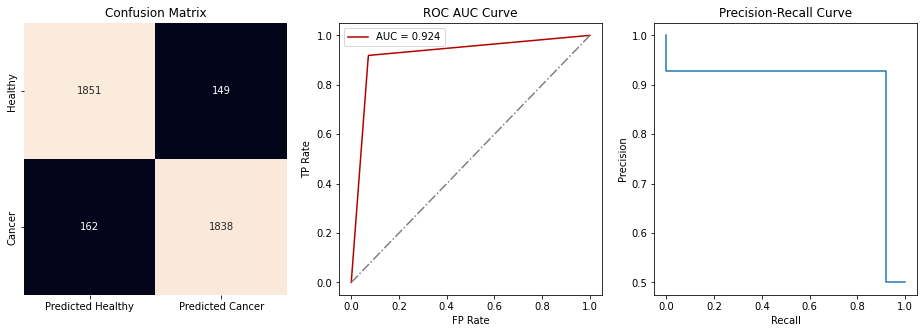

['ca125_level']
+----+---------------+---------------------+--------------+--------------+------------+-------------+----------+------------+
|    | top_feature   |   num_features_used |   importance |   tree_depth |   accuracy |   precision |   recall |   f1-score |
|----+---------------+---------------------+--------------+--------------+------------+-------------+----------+------------|
|  0 | ca125_level   |                 102 |        0.102 |           41 |    0.92225 |    0.925013 |    0.919 |   0.921996 |
+----+---------------+---------------------+--------------+--------------+------------+-------------+----------+------------+


In [741]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import make_pipeline
classifiers = {
    # 'LogisticRegression': LogisticRegression(C= 0.25, random_state= 0),
    # 'GaussianNB': GaussianNB(var_smoothing= 1e-09),
    'DecisionTreeClassifier': DecisionTreeClassifier(criterion= 'entropy', random_state= 0),
    # 'RandomForestClassifier': RandomForestClassifier(criterion= 'gini', n_estimators= 200, random_state= 0),
    # 'XGBClassifier': XGBClassifier(eval_metric= 'error', learning_rate= 0.1)
}
# trial_x = x[top_100_features[:50]]
plot_tree = False
label = 'cancer_in_next_1_years' # 'cancer_in_next_10_years', 'ovar_cancer'
trial_x = merged_df
# trial_x[label] = trial_x['ovar_cancer']
df_feature_importance_tree = None
df_top_feature_importances = []
drop_n_features = 1
k=10
for i in range(drop_n_features):
    
    train_test_lambda, k_fold_lambdas = process_and_impute_for_label_kfold(trial_x, label, 'median', n_max_per_class=10000, k=k)
    X_train, X_test, y_train, y_test = train_test_lambda()
    # X_train, X_test, y_train, y_test = process_and_impute_for_label(trial_x, label, 'median', n_max_per_class=10000)
    auc_dict = {}
    accuracy_dict = {}
    top_feature_importance = []
    for classifier_type, classifier in classifiers.items():
        # Cross Validation
        cv_scores = []
        pipeline = make_pipeline(StandardScaler(), classifier)
        for k_fold_lambda in k_fold_lambdas:
            X_train_cv, X_test_cv, y_train_cv, y_test_cv = k_fold_lambda()
            pipeline.fit(X_train_cv, y_train_cv)
            score = pipeline.score(X_test_cv, y_test_cv)
            cv_scores.append(score)
            print('Fold: %2d, Training/Test Split Distribution: %s, Accuracy: %.3f' % (k+1, np.bincount(y_train_cv), score))
        
        print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(cv_scores), np.std(cv_scores)))

        # Test classifier
        print(classifier_type)
        auc, accuracy = run_classifier(classifier, X_train, X_test, y_train, y_test)

        # Decision Tree feature selection
        if classifier_type == 'DecisionTreeClassifier':
            fn=X_train.columns
            if plot_tree:
                cn=['no cancer', 'cancer']
                fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
                tree.plot_tree(classifier,
                    feature_names = fn, 
                    class_names=cn,
                    filled = True)
                plt.show()
            feature_importances = pd.DataFrame(classifier.feature_importances_,
                                index = fn,
                                columns=['importance']).sort_values('importance', 
                                                                    ascending=False)
            feature_importances['feature'] = feature_importances.index
            feature_importances = feature_importances[['feature', 'importance']]
            feature_importances.to_csv('./feature_importance.csv')
            top_feature_importance.append(feature_importances.iloc[0]['feature'])
            y_pred = classifier.predict(X_test)
            y_prob = classifier.predict_proba(X_test)[:,1]
            # TODO: boundary and confusion matrix
            df_top_feature_importances.append({
                'top_feature': feature_importances.iloc[0]['feature'],
                # 'boundary': 0,
                'num_features_used': len(feature_importances[feature_importances['importance'] > 0]),
                'importance': round(feature_importances.iloc[0]['importance'], 3),
                'tree_depth': classifier.tree_.max_depth,
                'accuracy': accuracy,
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'f1-score': f1_score(y_test, y_pred),
            })
            if df_feature_importance_tree is not None:
                df_feature_importance_tree = df_feature_importance_tree.merge(feature_importances, on='feature', how='outer', suffixes=[f'_tiral_{i}', f'_tiral_{i+1}'])
            else:
                df_feature_importance_tree = feature_importances
            # print_df(feature_importances)
        auc_dict[classifier_type] = auc
        accuracy_dict[classifier_type] = accuracy
    trial_x = trial_x.drop(top_feature_importance, axis=1)
    print(top_feature_importance)

# df_feature_importance_tree = df_feature_importance_tree[df_feature_importance_tree['importance'] > 0]
# print_df(df_feature_importance_tree)
print_df(pd.DataFrame(df_top_feature_importances))
pd.DataFrame(df_top_feature_importances).to_csv(f'./top_{drop_n_features}_features_decision_tree.csv')

In [742]:

pd.DataFrame(df_top_feature_importances).to_csv('./top_features_decision_tree.csv')

In [743]:
pd.DataFrame(df_top_feature_importances)['top_feature'].to_list()

['ca125_level']

In [744]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
    XGBClassifier(),
    LogisticRegression(max_iter=200)
]
# Calculate years before cancer
def f_score(X_train, X_test, y_train, y_test, classifiers):
    for clf in classifiers:
        s = time.time()
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        f = f1_score(y_true=y_test,y_pred=y_pred,average="macro")
        e = time.time()
        print(f"Score: {round(f,3)} \t Time(in secs): {round(e-s,3)} \t Classifier: {clf.__class__.__name__}")
# f_score(X_train, X_test, y_train, y_test, classifiers)

In [745]:
def select_using_model():
    sel = SelectFromModel(XGBClassifier())
    sel.fit(x,y)

In [746]:
def select_using_score_func():
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # what are scores for the features
    features_scores = pd.DataFrame(x.columns)
    features_scores['scores'] = fs.scores_
    features_scores = features_scores.sort_values('scores', ascending=False)
    features_scores.to_csv('./feature_selection/all_features_new_cols__mean_imputed.csv')

In [747]:
# Determine on which features to use mean imputation and on which ones to replace with -1

 The initial dataset had 181 variables (Appendix 1). Variables were ranked by their F-score, which is the harmonic mean of precision and recall, with those with an F-score closest to 1.0 demonstrating high correlation with treatment success [10]. Experts in the treatment of BPH also selected variables for inclusion into the models irrespective of the F-Score, these variables, plus those with a high F-Score were selected for inclusion in initial model development.. The actual variables used by our models were a subset of these, and the number in any given fold and subgroup was dynamically determined by treating this as a hyper-parameter and tuning it as described below.